# Lesson 2: LangGraph Components

In [1]:
import os
from dotenv import load_dotenv

# Try to load from current directory, parent, and /home/jovyan/work (Docker mount)
load_dotenv()  # Current directory
load_dotenv('/home/jovyan/work/.env')  # Docker mounted directory

# Verify it's loaded
if os.getenv("TAVILY_API_KEY"):
    print("✅ TAVILY_API_KEY loaded successfully")
else:
    print("⚠️ TAVILY_API_KEY not found. Please set it in Docker environment or mount the workspace folder.")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Checking for .env files...")
    for path in ['.env', '../.env', '/home/jovyan/work/.env']:
        exists = os.path.exists(path)
        print(f"  {path}: {'✅ exists' if exists else '❌ not found'}")

✅ TAVILY_API_KEY loaded successfully


In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

## Import Explanations

**LangGraph (Graph Framework):**
- `StateGraph` - Creates a graph/flowchart of agent steps
  - Nodes = functions (like "call LLM", "use tool")
  - Edges = connections between steps
- `END` - Special constant marking the final node (stops execution)

**Typing (Type Hints):**
- `TypedDict` - Dictionary with predefined keys and types
  - Example: `class MyState(TypedDict): name: str`
- `Annotated` - Adds metadata/instructions to types
  - Example: `Annotated[list, operator.add]` means "append to this list"
- `operator` - Built-in Python operators as functions
  - `operator.add` = `+` operator (concatenate/add)

**LangChain Messages:**
- `AnyMessage` - Base type for any message type
- `HumanMessage` - User's messages (input from human)
- `SystemMessage` - System instructions/prompts for the AI
- `ToolMessage` - Results returned from tool/function calls

**LangChain AI Services:**
- `ChatOpenAI` - OpenAI's chat models (GPT-4, etc.)
  - Compatible with OpenAI-like APIs (Ollama, Groq, etc.)
- `TavilySearchResults` - Web search tool
  - Searches the internet and returns relevant results
  - Requires TAVILY_API_KEY

In [3]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


/tmp/ipykernel_25225/1287549681.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4)


In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

## Understanding AgentState

```python
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
```

**Keyword Breakdown:**

1. **`class`** - Python keyword to define a new class

2. **`AgentState`** - The name of your state class (you can name it anything)

3. **`TypedDict`** - A special dictionary type from Python's `typing` module
   - Like a regular dict but with type hints for each field
   - Example: `{"messages": [msg1, msg2]}`

4. **`messages`** - The field/key name in your state dict
   - This will store the conversation history

5. **`Annotated[...]`** - Adds metadata/instructions to a type
   - Format: `Annotated[Type, metadata]`

6. **`list[AnyMessage]`** - The actual type
   - `list` - A Python list
   - `[AnyMessage]` - List contains message objects (HumanMessage, SystemMessage, etc.)

7. **`operator.add`** - The metadata/instruction
   - Tells LangGraph HOW to update this field
   - `operator.add` means **concatenate/append** new messages to existing ones
   - Like doing: `old_messages + new_messages`

**In Practice:**
```python
# Initial state
state = {"messages": [HumanMessage(content="Hi")]}

# New state update 
new_state = {"messages": [SystemMessage(content="Hello!")]}

# operator.add combines them:
# result = [HumanMessage("Hi"), SystemMessage("Hello!")]
```

**Other operators you could use:**
- `operator.add` - Concatenate lists/add numbers
- Custom functions - Your own merge logic

In [4]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content = self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ....bad tool name.... \n")    # check for bad tool name from LLM
                result = "bad tool name, retry"         # instruct LLm to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

## Agent Class Explanation

### `__init__` - Building the Graph

```python
def __init__(self, model, tools, system=""):
    self.system = system  # System prompt/instructions
    graph = StateGraph(AgentState)  # Create empty graph
```

**Build the workflow:**
```python
graph.add_node("llm", self.call_openai)      # Node 1: Call LLM
graph.add_node("action", self.take_action)   # Node 2: Execute tools
```

**Define the flow:**
```python
graph.add_conditional_edges(
    "llm",                    # From: llm node
    self.exists_action,       # Check: does LLM want to use tools?
    {True: "action",          # If yes → go to action node
     False: END}              # If no → stop (done)
)
```

```python
graph.add_edge("action", "llm")  # After action → back to llm
graph.set_entry_point("llm")      # Start at llm node
self.graph = graph.compile()      # Finalize the graph
```

**The flow looks like:**
```
START → llm → needs tools? 
              ├─ Yes → action → llm (loop back)
              └─ No  → END
```

**Setup tools and model:**
```python
self.tools = {t.name: t for t in tools}  # Dict: {"tool_name": tool_object}
self.model = model.bind_tools(tools)      # Tell LLM about available tools
```

---

### `exists_action` - Check if LLM wants to use tools

```python
def exists_action(self, state: AgentState):
    result = state['messages'][-1]      # Get last message (LLM's response)
    return len(result.tool_calls) > 0   # True if LLM called tools
```

**Returns:**
- `True` if LLM wants to use tools → go to "action" node
- `False` if LLM gave final answer → END

---

### `call_openai` - Call the LLM

```python
def call_openai(self, state: AgentState):
    messages = state['messages']  # Get conversation history
    
    if self.system:
        # Add system prompt at the beginning
        messages = [SystemMessage(content=self.system)] + messages
    
    message = self.model.invoke(messages)  # Call LLM
    return {'messages': [message]}         # Return LLM's response
```

**Returns:** Dict with new message to add to state

---

### `take_action` - Execute tools

```python
def take_action(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls  # Get tools LLM wants to call
    results = []
    
    for t in tool_calls:
        print(f"Calling: {t}")
        
        # Check for hallucinated/bad tool names
        if not t['name'] in self.tools:
            print("\n ....bad tool name.... \n")
            result = "bad tool name, retry"  # Tell LLM to try again
        else:
            # Execute the actual tool
            result = self.tools[t['name']].invoke(t['args'])
        
        # Package result as ToolMessage
        results.append(ToolMessage(
            tool_call_id=t['id'],
            name=t['name'],
            content=str(result)
        ))
    
    print("Back to the model!")
    return {'messages': results}  # Return tool results
```

**Returns:** Dict with tool results to add to state

**Flow:** LLM sees tool results → decides next step (use more tools or give final answer)

In [6]:

prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
IMPORTANT: Answer ALL questions completely before stopping. Do not ask for confirmation."""

#model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
model = ChatOpenAI(base_url="http://host.docker.internal:11434/v1",
    api_key="ollama",  # Ollama doesn't need a real API key
    model="qwen2.5:14b")  # Better for tool calling than coder variant
abot = Agent(model, [tool], system=prompt)

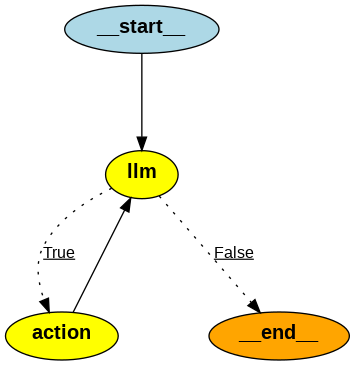

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())


In [8]:
messages = [ HumanMessage(content="What is the weather in SG?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in SG'}, 'id': 'call_2dmfzwkd', 'type': 'tool_call'}
Back to the model!


In [9]:
def print_result(result, max_len=500):
    """Pretty print agent result with truncation for long content"""
    import json
    
    print("\n" + "="*70)
    print("🤖 AGENT WORKFLOW RESULT")
    print("="*70)
    
    for i, msg in enumerate(result['messages'], 1):
        msg_type = type(msg).__name__
        
        # Header with emoji
        emoji = {"HumanMessage": "👤", "AIMessage": "🤖", "ToolMessage": "🔧", "SystemMessage": "⚙️"}
        print(f"\n{emoji.get(msg_type, '📨')} Step {i}: {msg_type}")
        print("-" * 70)
        
        # Content (truncated if too long)
        if hasattr(msg, 'content') and msg.content:
            content = str(msg.content)
            if len(content) > max_len:
                print(f"💬 Content: {content[:max_len]}... [truncated, {len(content)} total chars]")
            else:
                print(f"💬 Content: {content}")
        
        # Tool calls
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            print(f"\n🛠️  Tool Calls ({len(msg.tool_calls)}):")
            for tc in msg.tool_calls:
                print(f"  • {tc['name']}")
                args_str = json.dumps(tc['args'], indent=4)
                if len(args_str) > 200:
                    print(f"    {args_str[:200]}... [truncated]")
                else:
                    print(f"    {args_str}")
        
        # Token usage
        if hasattr(msg, 'response_metadata'):
            usage = msg.response_metadata.get('token_usage', {})
            if usage:
                total = usage.get('total_tokens', 0)
                inp = usage.get('prompt_tokens', 0)
                out = usage.get('completion_tokens', 0)
                print(f"\n💰 Tokens: {total} (in: {inp} | out: {out})")
    
    print("\n" + "="*70 + "\n")


In [ ]:

# Use it
print_result(result)

In [10]:
result

{'messages': [HumanMessage(content='What is the weather in SG?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="To provide you with the most accurate information, I need to clarify whether SG refers to Singapore or another location. However, since it's commonly known that SG stands for Singapore, let me check the current weather there.\n", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 231, 'total_tokens': 301, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen2.5:14b', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-611', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c6a9e-9ce4-7b21-be20-a8f39adec368-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in SG'}, 'id': 'call_2dmfzwkd', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 231, 'output_tokens

In [11]:
result['messages'][-1].content

'The current weather report from TimeAndDate for Singapore on February 17, 2026, reveals that the weather conditions are overcast with temperatures hovering around mid-70s Fahrenheit (around 24 to 25 degrees Celsius) in the early morning hours and gradually increasing to near 80°F by noon. The maximum temperature expected today is about 83°F during the afternoon. There has been no reported precipitation, but relative humidity remains quite high at around 86%. Sunshine duration seems consistent with approximately 9 hours daily.\n\nIf you are specifically interested in more recent or real-time data for Singapore not from a year ahead, please let me know and I can fetch that information as well.'

In [12]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_76ltvgi8', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_3s1l9nhx', 'type': 'tool_call'}
Back to the model!


In [13]:
result['messages'][-1].content

"Here's the weather forecast for San Francisco and Los Angeles on February 17, 2026:\n\n### **San Francisco**\n- Feels like temperature: 8°C (feels like 4°C)\n- Conditions: Chance of rain. Cold.\n- Wind direction & speed: WSW / 29 km/h Moderate Breeze\n- Rain possibility: 60%\n\n---\n### **Los Angeles**\n- Feels like temperature: 8°C (feels like 5°C)\n- Conditions: Sunny. Cool.\n- Wind direction & speed: SW / 22 km/h Moderate Breeze\n- Rain possibilities: None expected, but some areas may experience heavy rain and debris flows due to extended wet conditions.\n\nBoth cities are expecting chilly temperatures with varying chances of precipitation, though San Francisco has a higher probability of rainfall while Los Angeles might face extreme weather events this week."

In [14]:
print_result(result)


🤖 AGENT WORKFLOW RESULT

👤 Step 1: HumanMessage
----------------------------------------------------------------------
💬 Content: What is the weather in SF and LA?

🤖 Step 2: AIMessage
----------------------------------------------------------------------
💬 Content:  limburg Weather.com is typically reliable for current weather information.


🛠️  Tool Calls (2):
  • tavily_search_results_json
    {
    "query": "current weather in San Francisco"
}
  • tavily_search_results_json
    {
    "query": "current weather in Los Angeles"
}

💰 Tokens: 312 (in: 233 | out: 79)

🔧 Step 3: ToolMessage
----------------------------------------------------------------------
💬 Content: [{'title': 'San Francisco weather in February 2026 | Weather25.com', 'url': 'https://www.weather25.com/north-america/usa/california/san-francisco?page=month&month=February', 'content': 'weather25.com\nSearch\nweather in United States\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in United Stat

In [ ]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

In [16]:
print_result(result)


🤖 AGENT WORKFLOW RESULT

👤 Step 1: HumanMessage
----------------------------------------------------------------------
💬 Content: What is the weather in SF and LA?

🤖 Step 2: AIMessage
----------------------------------------------------------------------
💬 Content:  limburg Weather.com is typically reliable for current weather information.


🛠️  Tool Calls (2):
  • tavily_search_results_json
    {
    "query": "current weather in San Francisco"
}
  • tavily_search_results_json
    {
    "query": "current weather in Los Angeles"
}

💰 Tokens: 312 (in: 233 | out: 79)

🔧 Step 3: ToolMessage
----------------------------------------------------------------------
💬 Content: [{'title': 'San Francisco weather in February 2026 | Weather25.com', 'url': 'https://www.weather25.com/north-america/usa/california/san-francisco?page=month&month=February', 'content': 'weather25.com\nSearch\nweather in United States\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in United Stat

In [17]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(base_url="http://host.docker.internal:11434/v1",
    api_key="ollama",  # Ollama doesn't need a real API key
    model="qwen2.5:14b")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl winner 2024'}, 'id': 'call_rx8lek4l', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'headquarters location of [TEAM_NAME]'}, 'id': 'call_vae3xqz7', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of [STATE_NAME] state in 2024'}, 'id': 'call_h8fjwhh4', 'type': 'tool_call'}
Back to the model!


In [18]:
print_result(result)


🤖 AGENT WORKFLOW RESULT

👤 Step 1: HumanMessage
----------------------------------------------------------------------
💬 Content: Who won the super bowl in 2024? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.

🤖 Step 2: AIMessage
----------------------------------------------------------------------
💬 Content: Let's start by finding out who won the Super Bowl in 2024.


🛠️  Tool Calls (3):
  • tavily_search_results_json
    {
    "query": "Super Bowl winner 2024"
}
  • tavily_search_results_json
    {
    "query": "headquarters location of [TEAM_NAME]"
}
  • tavily_search_results_json
    {
    "query": "GDP of [STATE_NAME] state in 2024"
}

💰 Tokens: 377 (in: 258 | out: 119)

🔧 Step 3: ToolMessage
----------------------------------------------------------------------
💬 Content: [{'title': "Who won the Super Bowl in 2024? Revisiting Chiefs' win over 49ers", 'url': 'https://www.lubbockonline.com/story/sports/nfl/2025/02/09/w

In [11]:
from langchain_community.tools import DuckDuckGoSearchRun
tool = DuckDuckGoSearchRun()
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

prompt = """You are a smart research assistant with main language as English. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
IMPORTANT: Answer ALL questions completely before stopping. Do not ask for confirmation."""

query = "Whats is the date today in Singapore? Is it a public holiday? What is this holiday and What should I do today as a Chinese?" 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(base_url="http://host.docker.internal:11434/v1",
    api_key="ollama",  # Ollama doesn't need a real API key
    model="qwen2.5:14b")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})


Calling: {'name': 'duckduckgo_search', 'args': {'query': 'date today in singapore'}, 'id': 'call_ekulqpat', 'type': 'tool_call'}
Calling: {'name': 'duckduckgo_search', 'args': {'query': 'public holidays in singapore for the current date'}, 'id': 'call_nh8ulywf', 'type': 'tool_call'}
Calling: {'name': 'duckduckgo_search', 'args': {'query': 'cultural activities for chinese new year celebrations if today is cny in singapore or nearest upcoming chinese new year traditions in singapore'}, 'id': 'call_50fvn6xl', 'type': 'tool_call'}
Back to the model!


In [12]:
print_result(result)


🤖 AGENT WORKFLOW RESULT

👤 Step 1: HumanMessage
----------------------------------------------------------------------
💬 Content: Whats is the date today in Singapore? Is it a public holiday? What is this holiday and What should I do today as a Chinese?

🤖 Step 2: AIMessage
----------------------------------------------------------------------

🛠️  Tool Calls (3):
  • duckduckgo_search
    {
    "query": "date today in singapore"
}
  • duckduckgo_search
    {
    "query": "public holidays in singapore for the current date"
}
  • duckduckgo_search
    {
    "query": "cultural activities for chinese new year celebrations if today is cny in singapore or nearest upcoming chinese new year traditions in singapore"
}

💰 Tokens: 350 (in: 251 | out: 99)

🔧 Step 3: ToolMessage
----------------------------------------------------------------------
💬 Content: 3 hours ago · Current local time in Singapore – Singapore. Get Singapore's weather and area codes, time zone and DST. Explore Singapore's s

In [13]:
prompt = """You are a smart research assistant with main language as English. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
IMPORTANT: Answer ALL questions completely before stopping. Do not ask for confirmation."""

query = "Whats is the date today in Singapore? Is it a public holiday? What is this holiday and What should I do today as a Chinese?" 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
tool = TavilySearchResults(max_results=4)
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

/tmp/ipykernel_25933/2859869314.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4)


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current date in Singapore'}, 'id': 'call_aLkOjoR5iPjTWiGznleQ7GtN', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Singapore public holidays today'}, 'id': 'call_qL22UMkWNEgc6nWIk80nRioF', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'activities for Chinese during this public holiday in Singapore'}, 'id': 'call_jluwpTBitPGsy1qnfW2TU1DK', 'type': 'tool_call'}
Back to the model!


In [14]:
print_result(result)


🤖 AGENT WORKFLOW RESULT

👤 Step 1: HumanMessage
----------------------------------------------------------------------
💬 Content: Whats is the date today in Singapore? Is it a public holiday? What is this holiday and What should I do today as a Chinese?

🤖 Step 2: AIMessage
----------------------------------------------------------------------

🛠️  Tool Calls (3):
  • tavily_search_results_json
    {
    "query": "current date in Singapore"
}
  • tavily_search_results_json
    {
    "query": "Singapore public holidays today"
}
  • tavily_search_results_json
    {
    "query": "activities for Chinese during this public holiday in Singapore"
}

💰 Tokens: 254 (in: 170 | out: 84)

🔧 Step 3: ToolMessage
----------------------------------------------------------------------
💬 Content: [{'title': 'SGT Time Now Singapore Time - UTC Time', 'url': 'https://www.utctime.net/sgt-time-now', 'content': '# SGT Time Now\n\nSGT is the abbreviation of Singapore Time. Time zone offset of SGT is UTC+08.\n